In [103]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np
import seaborn as sns

In [104]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [105]:
df.shape

(200, 5)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [107]:
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [108]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [109]:
df['Genre'].value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

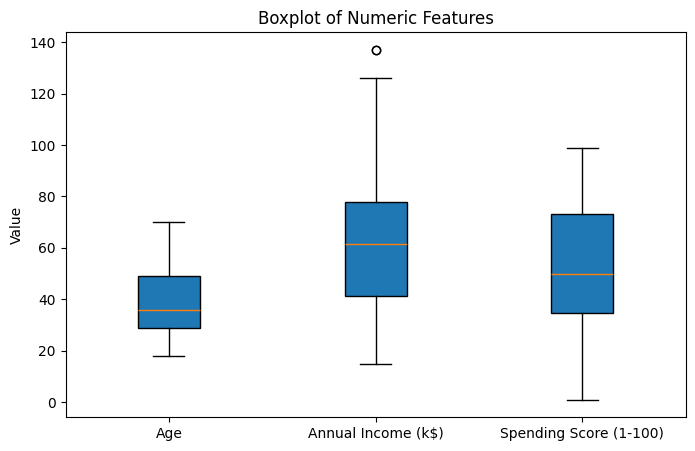

In [110]:
df = df.drop(['CustomerID'], axis=1)
numerical=df.select_dtypes(include='number')
plt.figure(figsize=(8, 5))

plt.boxplot(numerical.values, patch_artist=True, labels=numerical.columns)
plt.title("Boxplot of Numeric Features")
plt.ylabel('Value')
plt.show()

In [111]:
df = df.drop(['Age'], axis=1)
df.sample(5)

,Genre,Annual Income (k$),Spending Score (1-100)
157,Female,78,78
130,Male,71,9
1,Male,15,81
106,Female,63,50
126,Male,71,35


In [112]:
numeric_columns = [ 'Annual Income (k$)', 'Spending Score (1-100)']

X = df[numeric_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## DBSCAN Clustering :

In [114]:
def dbscan_scratch(X, eps, min_samples):
    """
    Returns: An array of cluster labels for each data point. Noise points are labeled -1.
    """
    # Helper function to find all neighbors for a given point
    def region_query(point_index):
        
        distances = np.linalg.norm(X - X[point_index], axis=1)  # Calculate Euclidean distances from the point to all other points 
        return np.where(distances <= eps)[0]    # Return indices of points within the eps radius 

    n_points = X.shape[0]
    # Initialize all labels to 0 (unclassified)
    labels = np.zeros(n_points, dtype=int)
    cluster_id = 0

    # Iterate over each point in the dataset
    for i in range(n_points):
        # Skip if the point has already been visited (classified)
        if labels[i] != 0:
            continue

        # Find neighbors for the current point
        neighbors = region_query(i)

        # If the number of neighbors is less than min_samples, mark as noise (-1)
        if len(neighbors) < min_samples:
            labels[i] = -1
            continue

        # This is a core point, so start a new cluster
        cluster_id += 1
        labels[i] = cluster_id

        # Use a queue to expand the cluster from the core point's neighbors
        queue = list(neighbors)

        while queue:
            # Get the next point from the queue
            current_point_idx = queue.pop(0)

            # If this point was marked as noise, it's now a border point
            if labels[current_point_idx] == -1:
                labels[current_point_idx] = cluster_id

            # If this point is unclassified, add it to the current cluster
            if labels[current_point_idx] == 0:
                labels[current_point_idx] = cluster_id

                # Find its neighbors
                current_neighbors = region_query(current_point_idx)

                # If it's also a core point, add its neighbors to the queue
                if len(current_neighbors) >= min_samples:
                    # Add new, unclassified neighbors to the queue for processing
                    for neighbor_idx in current_neighbors:
                        if labels[neighbor_idx] == 0 or labels[neighbor_idx] == -1:
                            queue.append(neighbor_idx)

    return labels 


In [115]:
clusters = dbscan_scratch(X_scaled, eps=0.4, min_samples=5)

df['cluster'] = clusters

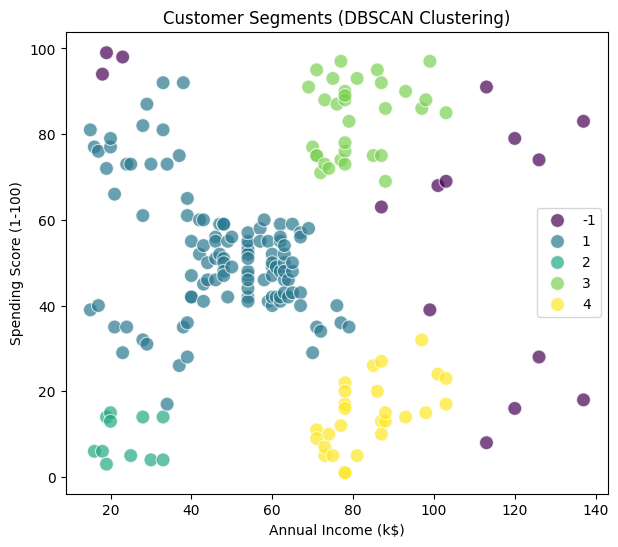

In [ ]:
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title("Customer Segments (DBSCAN Clustering)")
plt.legend()
plt.show()

In [120]:
# 3. Analyze the cluster profiles
cluster_profile = df.groupby('cluster')[numeric_columns].mean()
print("\nCluster Profiles (DBSCAN) :")
cluster_profile


Cluster Profiles (DBSCAN) :


,Annual Income (k$),Spending Score (1-100)
cluster,,
-1,96.133333,61.800000
1,48.304348,51.730435
2,23.727273,8.909091
3,80.875000,83.625000
4,83.925926,14.444444


In [ ]:
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Number of clusters found: 4
Number of noise points: 15
